# Titanic - Who Will Survive? (CSE 351 Project)
## Dane Meister, Michael Lieberman

### Contributions
- **Dane Meister**  
  - Data Cleaning & Preprocessing  
  - Feature Engineering  
  - EDA & Visual Analysis  
  - Visualizations & Documentation
  - Presentation Preparation

- **Michael Lieberman**
  - Model Experimentation  
  - Modeling & Evaluation  
  - Cross-validation & Metrics
  - Documentation
  - Presentation Preparation

  ## Project Objective
This project explores the famous Titanic dataset to predict passenger survival using machine learning.
The goal is to analyze factors affecting survival and build accurate prediction models. We clean the dataset,
engineer features, perform EDA, and build three classifiers — Logistic Regression, KNN, and SVM —
then evaluate and compare their performance.


In [241]:
# imports
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

In [242]:
# mount drive in google colab
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the project folder (ensure training and testing csv's are in dir location)
project_folder = '/content/drive/MyDrive/CSE351_Project'
os.chdir(project_folder)

# Confirm current directory
print('Current Directory:', os.getcwd())

# Load the training and testing data
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')

# Preview the first few rows
print("Training Data Preview:")
train_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/MyDrive/CSE351_Project
Training Data Preview:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [243]:
# Show basic info about the datasets
print("Train Data Info:")
train_data.info()

print("\nTest Data Info:")
test_data.info()

# Check missing values
print("Missing values in training set:")
print(train_data.isnull().sum())

print("\nMissing values in test set:")
print(test_data.isnull().sum())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418

## Data Cleaning Summary

- **Missing Values:**
  - `Age` filled using median values grouped by passenger `Title`
  - `Fare` filled with median and log-transformed to reduce skew
  - `Embarked` filled with most common value ('S')
- **Feature Dropping:**
  - Dropped `Cabin` due to sparsity, `Ticket`, and `Name` after extracting useful info
- **Outlier Handling:**
  - Clipped `Fare` values at the 99th percentile

## Feature Engineering Highlights

- Extracted `Title` from names (Mr, Miss, etc.)
- Created `FamilySize = SibSp + Parch + 1`
- Created binary `IsAlone` feature
- Created binary `HasCabin` feature
- Created binned `AgeGroup` (child, teen, adult, middle-aged, senior)
- Encoded categorical variables (`Sex`, `Embarked`, `Title`)


In [244]:
# Combine train and test for consistent transformations
train_data['Set'] = 'train'
test_data['Set'] = 'test'
full_data = pd.concat([train_data, test_data], sort=False)

print(f"Full dataset shape after combining: {full_data.shape}")

Full dataset shape after combining: (1309, 13)


In [245]:
# Check most common port
print(full_data['Embarked'].value_counts())

# 'S' (Southampton) is the most common, so we'll fill missing with 'S' (mode)
full_data['Embarked'] = full_data['Embarked'].fillna('S')

# Filling with the mode avoids skewing the distribution (only filling 2 values).

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64


In [246]:
# Only one fare is missing in the test set, we fill it with the median fare value

fare_median = full_data['Fare'].median()
full_data['Fare'] = full_data['Fare'].fillna(fare_median)

# We use median because fare is usually skewed and median is less sensitive to outliers.

# Find 99th percentile of Fare
fare_99 = full_data['Fare'].quantile(0.99)

# Clip Fare at 99th percentile
full_data['Fare'] = np.where(full_data['Fare'] > fare_99, fare_99, full_data['Fare'])

# Log-transform fare b/c of skew
# Taking the log of Fare reduces skewness and stabilizes variance.
# We use np.log1p() which computes log(1 + x), safely handling Fare = 0.

full_data['Fare'] = np.log1p(full_data['Fare'])

In [247]:
# Extract titles like Mr, Mrs, Miss, etc.
full_data['Title'] = full_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Show the unique titles
print(full_data['Title'].unique())

# Simplify rare titles
full_data['Title'] = full_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', \
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full_data['Title'] = full_data['Title'].replace('Mlle', 'Miss')
full_data['Title'] = full_data['Title'].replace('Ms', 'Miss')
full_data['Title'] = full_data['Title'].replace('Mme', 'Mrs')

# Why?
# - Too many rare titles would dilute the model.
# - Grouping uncommon titles together makes learning easier.

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


In [248]:
# Fill missing Age by grouping median by Title
# Create a mapping of Title -> Median Age
title_age_median = full_data.groupby('Title')['Age'].median()

# Define a function to fill missing ages
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_median[row['Title']]
    else:
        return row['Age']

# Apply the function
full_data['Age'] = full_data.apply(fill_age, axis=1)

# Why by Title?
# - Titles like 'Master' mean young boys, 'Mrs' are adult women, etc.
# - This is more accurate than just using Pclass or global median.

In [249]:
# FamilySize = Siblings/Spouses + Parents/Children + 1 (self)

full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1

# Why?
# - Larger families might survive differently (stick together, or harder to escape).
# - Alone passengers might behave differently too.

In [250]:
# Binary feature: 1 if passenger is alone, else 0
full_data['IsAlone'] = 0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

# Why?
# - Psychological and practical differences between traveling alone or with family.
# - Very strong survival indicator found in EDA from Kaggle Titanic competitions.

In [251]:
# New binary feature based on Cabin information
full_data['HasCabin'] = 0
full_data.loc[full_data['Cabin'].notnull(), 'HasCabin'] = 1

# After this, we will drop the original Cabin column
full_data = full_data.drop(['Cabin'], axis=1)

# Why?
# - Cabin number itself is too sparse and messy.
# - But knowing if someone had a cabin (1st class luxury?) could affect survival.

In [252]:
# Sex: male -> 0, female -> 1
full_data['Sex'] = full_data['Sex'].map({'male': 0, 'female': 1}).astype(int)

# Embarked: C -> 0, Q -> 1, S -> 2
full_data['Embarked'] = full_data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2}).astype(int)

# Title Encoding
# We map titles to numeric as well
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
full_data['Title'] = full_data['Title'].map(title_mapping).fillna(4).astype(int)

# Why?
# - Machine Learning models can't handle text data.
# - Encoding categories numerically allows models to learn patterns.

In [253]:
# Create age bins b/c raw age can cause overfitting (small meaningless differences)
# Grouping into meaningful bins helps generalize better and reduce noise.

# Define age bins:
full_data['AgeGroup'] = pd.cut(full_data['Age'], bins=[0, 12, 18, 35, 60, 120],
                               labels=[0, 1, 2, 3, 4])

# Bins:
# 0 = Child (0-12)
# 1 = Teen (13-18)
# 2 = Young Adult (19-35)
# 3 = Middle Aged (36-60)
# 4 = Senior (60+)

print("Age binning applied!")
print(full_data[['Age', 'AgeGroup']].head(10))  # Quick check

Age binning applied!
    Age AgeGroup
0  22.0        2
1  38.0        3
2  26.0        2
3  35.0        2
4  35.0        2
5  29.0        2
6  54.0        3
7   2.0        0
8  27.0        2
9  14.0        1


In [254]:
# Drop columns that won't help in prediction
full_data = full_data.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

# Why?
# - Name and Ticket are too messy, and already extracted useful info from Name (Title).
# - PassengerId is just an identifier.

In [255]:
# Separate the cleaned full_data back to train and test
train_cleaned = full_data[full_data['Set'] == 'train'].drop(['Set'], axis=1)
test_cleaned = full_data[full_data['Set'] == 'test'].drop(['Set', 'Survived'], axis=1, errors='ignore')

# X (features) and y (target) for training
X_train = train_cleaned.drop('Survived', axis=1)
y_train = train_cleaned['Survived']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"test_cleaned shape: {test_cleaned.shape}")

X_train shape: (891, 12)
y_train shape: (891,)
test_cleaned shape: (418, 12)


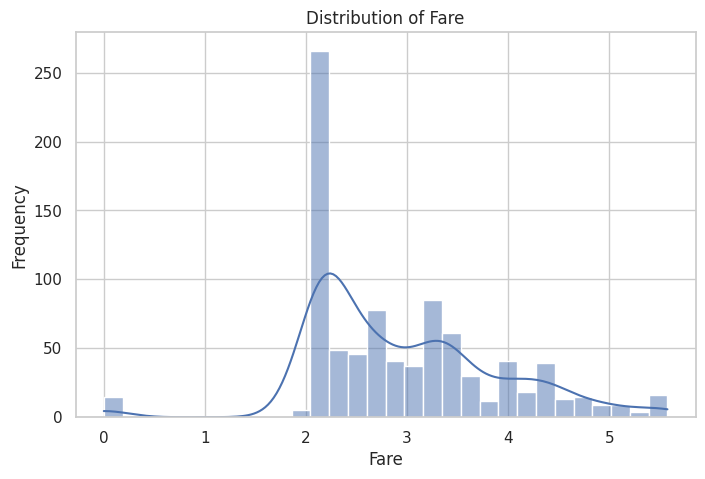

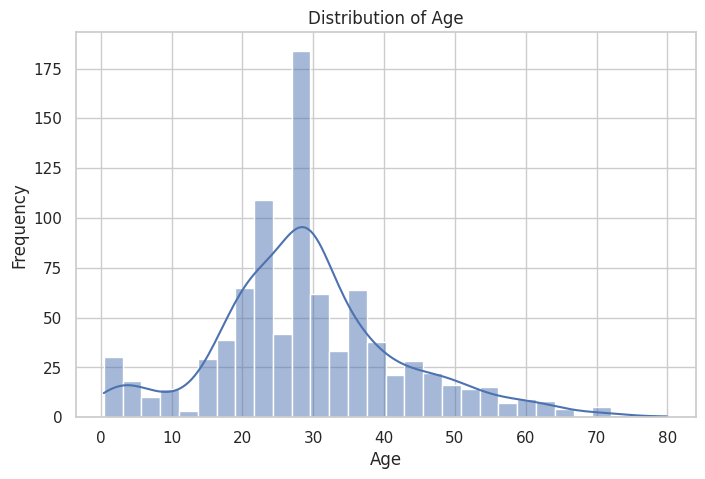

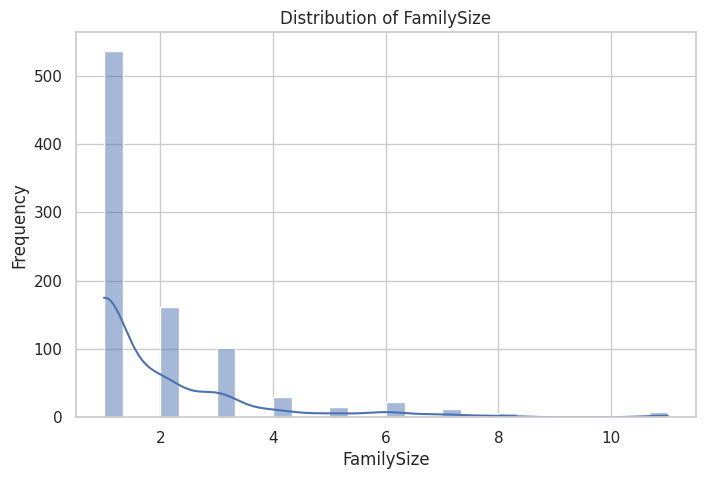

In [256]:
# Set a visual style
sns.set(style="whitegrid")

# Plot distributions for key numeric features
# Features to plot
features_to_plot = ['Fare', 'Age', 'FamilySize']

# Create histograms
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=X_train, x=feature, kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Why?
# - Helps spot skewness, outliers
# - KDE (Kernel Density Estimate) shows smooth distribution curve

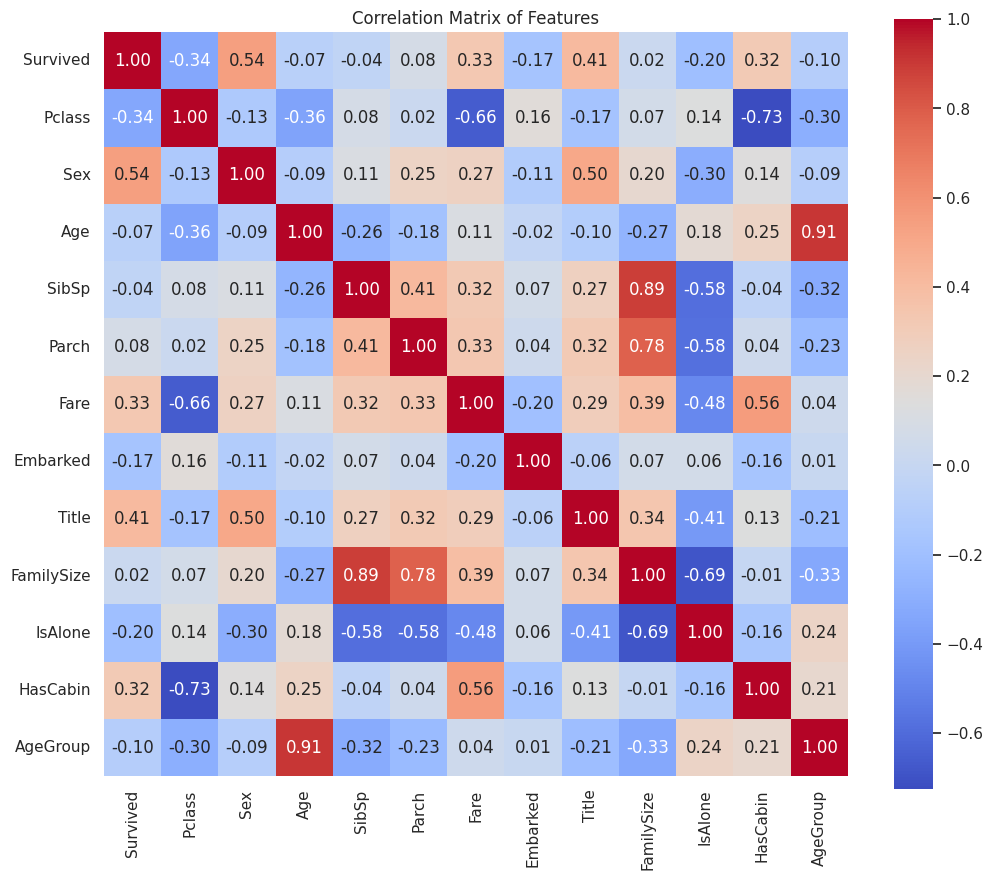

In [257]:
# Correlation Heatmap

# We add 'Survived' back temporarily for correlation
corr_matrix = train_cleaned.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()

# Why?
# - See relationships between features
# - High correlations (>0.7 or <-0.7) between independent features can signal multicollinearity.
# - Check how features correlate with Survived (target)!

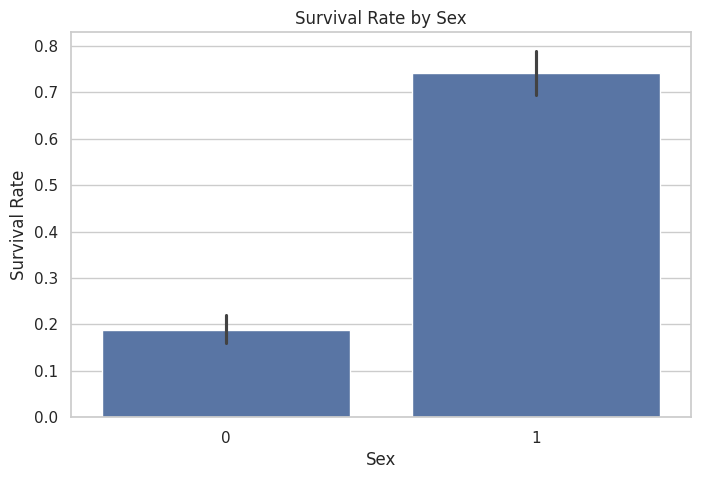

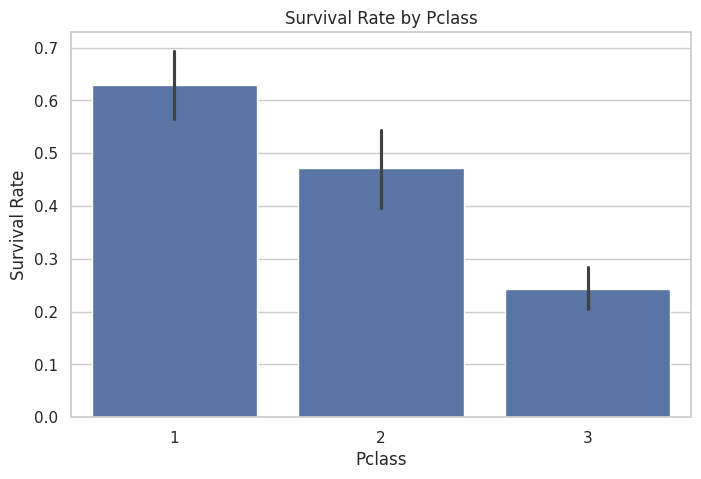

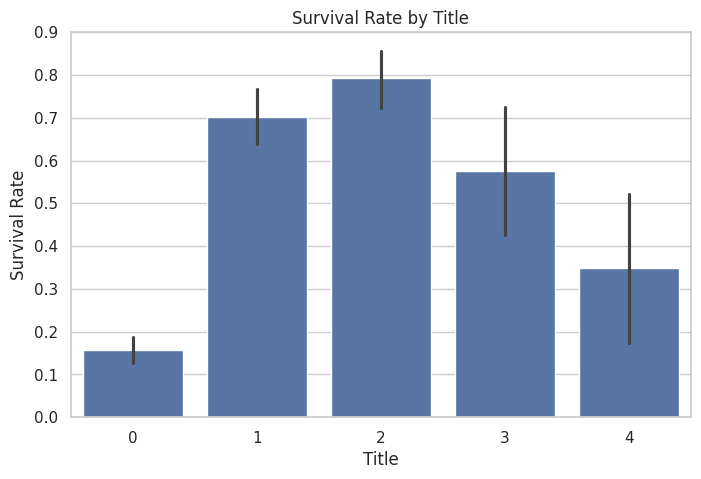

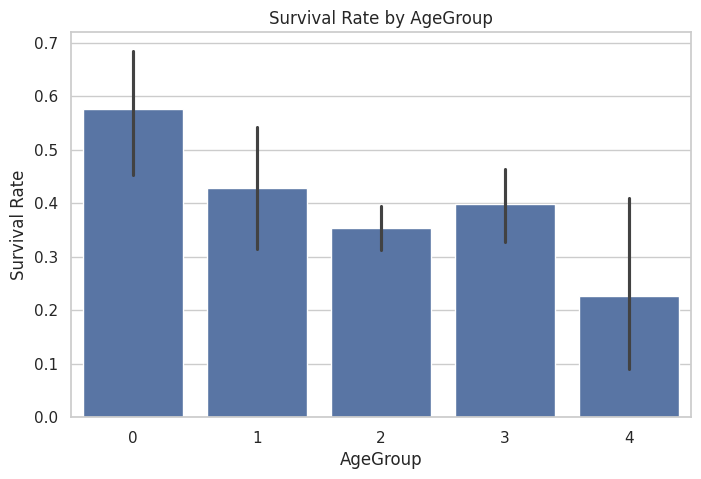

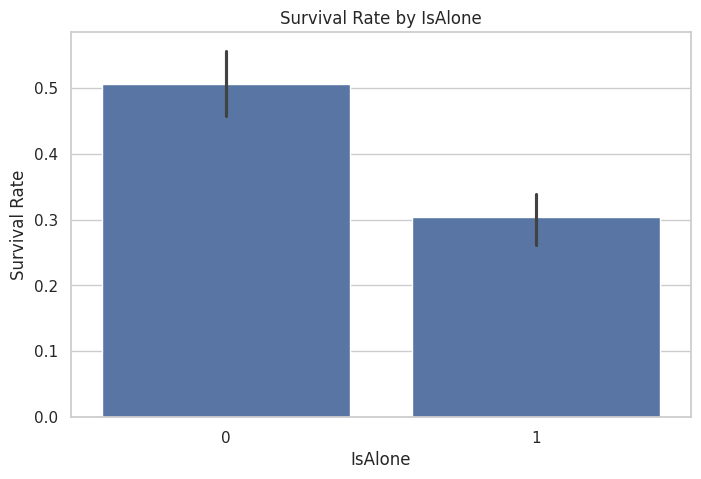

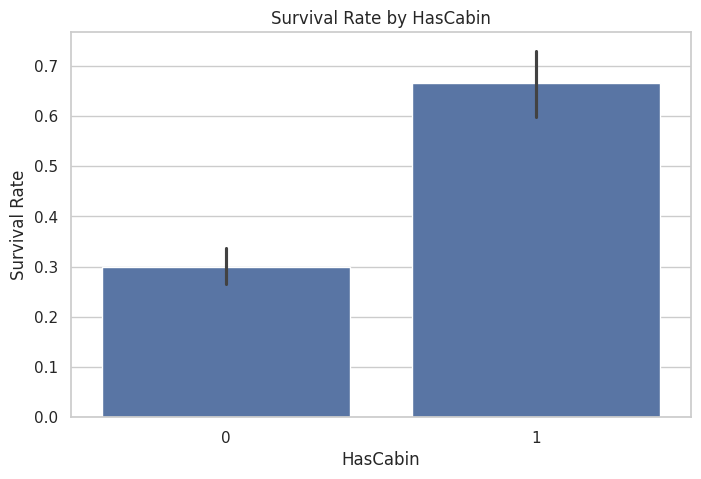

In [258]:
# Survival rates by categorical features

# Function to plot survival rate barplots
def survival_rate_by_feature(feature):
    plt.figure(figsize=(8,5))
    sns.barplot(x=feature, y='Survived', data=train_cleaned)
    plt.title(f'Survival Rate by {feature}')
    plt.ylabel('Survival Rate')
    plt.xlabel(feature)
    plt.show()

# Analyze key categorical features
categorical_features = ['Sex', 'Pclass', 'Title', 'AgeGroup', 'IsAlone', 'HasCabin']

for feature in categorical_features:
    survival_rate_by_feature(feature)

# Why?
# - Barplots give easy intuition about survival chances for different groups.
# - Confirm feature importance visually before modeling.

In [259]:
# Socioeconomic Status Exploration

# Let's summarize survival rate by Pclass and Sex
socioeconomic_summary = train_cleaned.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack()

print("Survival Rate by Socioeconomic Status (Pclass and Sex):")
print(socioeconomic_summary)

Survival Rate by Socioeconomic Status (Pclass and Sex):
Sex            0         1
Pclass                    
1       0.368852  0.968085
2       0.157407  0.921053
3       0.135447  0.500000


In [260]:
selected_features = [
    'Pclass',
    'Sex',
    'AgeGroup',
    'Fare',
    'Embarked',
    'Title',
    'IsAlone',
    'HasCabin'
]

# Predict survival based on the selected features
X_train = train_cleaned[selected_features]
y_train = train_cleaned['Survived'] # target survival

X_test = test_cleaned[selected_features]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (891, 8)
y_train shape: (891,)
X_test shape: (418, 8)


We trained three machine learning models:
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)

Evaluation was done using 5-fold cross-validation on the training data.
We used **Accuracy**, **Precision**, **Recall**, and **F1 Score** as evaluation metrics.

**Model Results:**
- **Logistic Regression**: Accuracy 80.6%, F1 Score 0.741
- **KNN**: Accuracy 80.4%, F1 Score 0.734 (*K=5 for KNN*)
- **SVM**: Accuracy 81.6%, F1 Score 0.743

# Logistic Regression
Logistic Regression is a classification algorithm used to predict binary outcomes, whether a passenger survived (1) or not (0). It works by estimating the probability that an instance belongs to a particular class using a logistic (sigmoid) function. The algorithm finds the best weights for each feature that maximize the likelihood of the observed outcomes in the training data. Logistic Regression is widely used for its simplicity, interpretability, and effectiveness in binary classification problems.
New Section

I trained the model using the selected features and evaluated its accuracy using 5-fold cross-validation. This helps ensure that the model's performance is not dependent on a particular split of the data.

After training, the model predicts whether passengers in the test set survived or not.


In [261]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=200)

# Cross-validation accuracy
logreg_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
print("Logistic Regression CV Accuracy:", logreg_scores.mean())

# Get cross-validated predictions for the training set
logreg_cv_preds = cross_val_predict(logreg, X_train, y_train, cv=5)

# Calculate metrics
logreg_precision = precision_score(y_train, logreg_cv_preds)
logreg_recall = recall_score(y_train, logreg_cv_preds)
logreg_f1 = f1_score(y_train, logreg_cv_preds)

print("Logistic Regression Precision:", logreg_precision)
print("Logistic Regression Recall:", logreg_recall)
print("Logistic Regression F1-Score:", logreg_f1)

# Fit the model on the entire training data
logreg.fit(X_train, y_train)
# Predict survival on the test data
logreg_preds = logreg.predict(X_test)
print("\nSample predictions:", logreg_preds[:10])

Logistic Regression CV Accuracy: 0.8058376749733224
Logistic Regression Precision: 0.7584097859327217
Logistic Regression Recall: 0.7251461988304093
Logistic Regression F1-Score: 0.7414050822122571

Sample predictions: [0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]


## K-Nearest Neighbor (KNN)
K-Nearest Neighbors (KNN) is an algorithm that predicts the outcome for a new data point by finding the k most similar data points in the training set. In this case, the model looks for passengers in the training data who have similar characteristics (such as class, sex, age group, fare, etc.). It then predicts survival based on whether most of these similar passengers survived or not. KNN does not build a mathematical model but instead makes predictions based on proximity in feature space.

I trained the KNN model using the selected features and evaluated its performance using 5-fold cross-validation.

The model predicts whether passengers in the test set survived or not based on the survival outcomes of their most similar passengers in the training set.

In [262]:
# Initialize K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5) # Using k=5

# Cross-validation accuracy
knn_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
print("KNN CV Accuracy:", knn_scores.mean())


# Cross-validated predictions for the training set
knn_cv_preds = cross_val_predict(knn, X_train, y_train, cv=5)

# Calculate metrics
knn_precision = precision_score(y_train, knn_cv_preds)
knn_recall = recall_score(y_train, knn_cv_preds)
knn_f1 = f1_score(y_train, knn_cv_preds)

print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)
print("KNN F1-Score:", knn_f1)

# Fit the model on the entire training data
knn.fit(X_train, y_train)
# Predict survival on the test data
knn_preds = knn.predict(X_test)
print("\nSample predictions (KNN):", knn_preds[:10])

KNN CV Accuracy: 0.8035842068922229
KNN Precision: 0.765079365079365
KNN Recall: 0.7046783625730995
KNN F1-Score: 0.7336377473363774

Sample predictions (KNN): [0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]


# Support Vector Machine (SVM)
SVM is a supervised learning algorithm that finds the optimal boundary (hyperplane) that best separates data points into classes. It works well for binary classification problems and can handle non-linear relationships using kernel functions.

I trained an SVM model and evaluated it using 5-fold cross-validation.

The model predicts survival outcomes for passengers in the test set.

In [263]:
# Initialize SVM
svm = SVC(kernel='rbf', random_state=42)

# Cross-validation accuracy
svm_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
print("SVM CV Accuracy:", svm_scores.mean())

# Cross-validated predictions for evaluation metrics
svm_cv_preds = cross_val_predict(svm, X_train, y_train, cv=5)

# Calculate metrics
svm_precision = precision_score(y_train, svm_cv_preds)
svm_recall = recall_score(y_train, svm_cv_preds)
svm_f1 = f1_score(y_train, svm_cv_preds)

print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1-Score:", svm_f1)

# Fit the model on the entire training data
svm.fit(X_train, y_train)
# Predict survival on the test data
svm_preds = svm.predict(X_test)
print("\nSample predictions (SVM):", svm_preds[:10])

SVM CV Accuracy: 0.8159060950348378
SVM Precision: 0.8006756756756757
SVM Recall: 0.6929824561403509
SVM F1-Score: 0.7429467084639498

Sample predictions (SVM): [0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]


In [264]:
# Load PassengerId from test.csv again
passenger_ids = pd.read_csv('titanic/test.csv')['PassengerId']

# Logistic Regression predictions
submission_logreg = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': logreg_preds.astype(int)
})
submission_logreg.to_csv('submission_logreg.csv', index=False)

# Save KNN predictions to CSV
submission_knn = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': knn_preds.astype(int)
})
submission_knn.to_csv('submission_knn.csv', index=False)

# SVM predictions
submission_svm = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': svm_preds.astype(int)
})
submission_svm.to_csv('submission_svm.csv', index=False)

print("All prediction CSVs saved successfully.")

All prediction CSVs saved successfully.


The CV accuracy tells you how often the model gets the predictions right on average. This is important since this value can show how well the model is likely to perform with new data.

Precision tells you how correct the model is when it predicts yes (for this, when the model predicts if the person survives). This is important so we can see that the model doesn't incorrectly predict survival when the passenger did not. This is good for avoiding false positives.

Recall is of all of the passengers who actually survived, how many are correctly identified by the model. This is important because it shows how well the model catches the true survivors (high recall meaning model catches the most). This is good for avoiding false negatives.

F1-Score takes the precision and recall values and balances them to a single score. This is important because it shows how well a model is able to both identify the survivors and avoid false positives and negatives.

5-Fold Cross-Validation is a way to test how well a model performs on new data. This method splits training data into 5 parts (folds). For the 5 runs it does, it trains on 4 folds and tests on the remianing fold. It rotates through each fold so they all get tested once, and at the end the score of the results get averaged together.

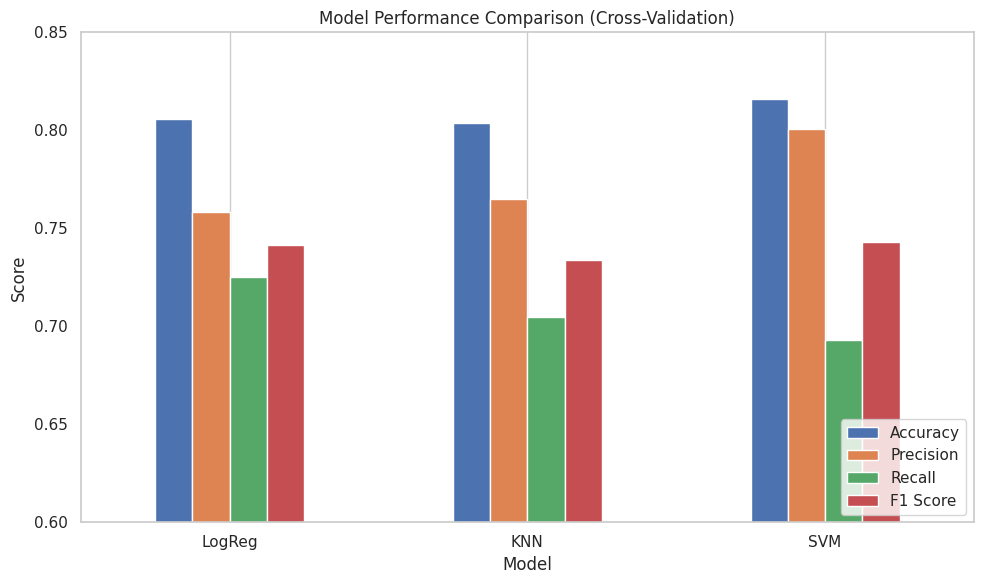

In [265]:
metrics_data = {
    'Model': ['LogReg', 'KNN', 'SVM'],
    'Accuracy': [0.8058, 0.8036, 0.8159],
    'Precision': [0.7584, 0.7651, 0.8007],
    'Recall': [0.7251, 0.7047, 0.6930],
    'F1 Score': [0.7414, 0.7336, 0.7429]
}

df_metrics = pd.DataFrame(metrics_data)

# Barplot comparison
df_metrics.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Cross-Validation)")
plt.ylabel("Score")
plt.ylim(0.6, 0.85)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Final model predictions were made on the test dataset (`test.csv`) using each trained model.
These predictions were saved as submission-ready CSV files:
- `submission_logreg.csv`
- `submission_rf.csv`
- `submission_svm.csv`

**Note**: Since the test set has no labels, performance on the test set is unknown.

## Conclusion

In this project, we explored the Titanic passenger dataset to predict survival outcomes using machine learning. Our approach covered every stage of the ML pipeline:

- **Data Cleaning:** We addressed missing values in `Age`, `Fare`, and `Embarked`, and removed extreme outliers (Fare > 99th percentile).
- **Feature Engineering:** Extracted meaningful features such as `Title`, `FamilySize`, `IsAlone`, and `HasCabin`, and binned `Age` into groups for generalization.
- **EDA:** Through visualizations and group statistics, we confirmed that `Sex`, `Pclass`, `Fare`, and `Title` were strongly associated with survival.
- **Modeling & Evaluation:** We trained three classifiers:
  - **Logistic Regression**
  - **K-Nearest Neighbors (KNN)** with K=5
  - **Support Vector Machine (SVM)** with RBF kernel

All models were evaluated using **5-fold cross-validation** on the training set, and the following results were obtained:

| Model              | Accuracy | Precision | Recall | F1 Score |
|--------------------|----------|-----------|--------|----------|
| Logistic Regression | 80.6%    | 0.758     | **0.725** | 0.741 |
| K-Nearest Neighbors | 80.4%    | 0.765     | 0.705 | 0.734 |
| Support Vector Machine | **81.6%** | **0.801** | 0.693 | **0.743** |

**Insights:**
- **SVM achieved the best accuracy and F1 Score overall**, with excellent precision.
- **Logistic Regression had the highest recall**, making it more sensitive to capturing true survivors.
- **KNN performed competitively**, with a well-balanced profile, though slightly lower on recall.

Final predictions were generated using all models and saved for submission. These predictions are based on the unseen test dataset and cannot be evaluated directly without ground truth labels.

### Potential Rooms for Improvement:
- Hyperparameter tuning (e.g., for SVM’s `C` and `gamma`, or different K values in KNN)
- Ensembling models to combine strengths
- Using additional features such as text from `Ticket` or grouping passengers by `Family`

Overall, our results show that with careful preprocessing, feature engineering, and validation, machine learning can effectively uncover survival patterns in historical datasets like Titanic.

